# Intrusion Detection on the KDD Cup 99 Data Set: Documentation
*— Daniel Jones*

## Notebook Setup

Libraries for Python session (see `readme.md` for installation instructions):

In [13]:
import matplotlib 
import numpy
import pandas
import seaborn

from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from statsmodels import api as sm

import warnings
warnings.filterwarnings('ignore')

Setup Jupyter with `rpy2` to allow embedding R, and `matplotlib` to allow inline plots.

In [14]:
# For inline plots within the notebook
%matplotlib inline
# Allows code cells to be intrepreted as R (put %%R on the first line) [^1]
%load_ext rpy2.ipython
# Render R output as HTML
from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
html.init_printing()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Libraries for R session (see `readme.md` for installation instructions):

In [15]:
%%R
library(caret)
library(ggplot2)

In [16]:
random_state = numpy.random.RandomState(0)

## Data Source

Each row in the data represents a single TCP connection, as described in the original task description [^2]:
> A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol.  Each connection is labeled as either normal, or as an attack, with exactly one specific attack type.



In [17]:
columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'connection_label']
connection_events = pandas.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz', names=columns)  # [^3]

In [18]:
connection_events.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
duration,0,0,0,0,0,0,0,0,0,0
protocol_type,tcp,tcp,tcp,tcp,tcp,tcp,tcp,tcp,tcp,tcp
service,http,http,http,http,http,http,http,http,http,http
flag,SF,SF,SF,SF,SF,SF,SF,SF,SF,SF
src_bytes,181,239,235,219,217,217,212,159,210,212
dst_bytes,5450,486,1337,1337,2032,2032,1940,4087,151,786
land,0,0,0,0,0,0,0,0,0,0
wrong_fragment,0,0,0,0,0,0,0,0,0,0
urgent,0,0,0,0,0,0,0,0,0,0
hot,0,0,0,0,0,0,0,0,0,1


In [19]:
connection_events.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.00,0.0,0.00,58329.0
src_bytes,494021.0,3025.610296,988218.101050,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.00,0.0,0.00,5155468.0
land,494021.0,0.000045,0.006673,0.0,0.00,0.0,0.00,1.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494021.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494021.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494021.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
logged_in,494021.0,0.148247,0.355345,0.0,0.00,0.0,0.00,1.0
num_compromised,494021.0,0.010212,1.798326,0.0,0.00,0.0,0.00,884.0


The `connection_label` column describes the source of each connection; either the name of the red-team which caused the event, or the string `normal.` which indicates normal network behaviour. 

The task is to create a model which can separate red-team behavour from normal network behaviour, so group the data into two labels: `normal` and `bad`.

In [20]:
def generate_label(connection_label):
    return 'normal.' if connection_label == 'normal.' else 'bad.'

connection_events['connection_label'] = connection_events['connection_label'].apply(func=generate_label)

Next, separate out the labels from the data set. 

In [21]:
connection_labels = connection_events.filter(['connection_label'], axis='columns')
connection_events = connection_events.drop(['connection_label'], axis='columns')

## Training and Testing Data

It is now necessary to split the data into training and testing sets. When doing this we should ask the following questions:

  1. Does the ratio of normal and bad connections need to be similar in the training and testing data? If so, we should use stratified testing.
    - Unless you include all types in the training set, the model won't necessarily be able to distinguish between the classes. Further, if we sample the incorrect ratio of classes in our training and testing sets, we have the potential to bias the model against rare classes.
  2. Should we consider k-fold validation?
    - What do we think? Yes: it helps to protect against overfitting of the data [^ref???] and allows us to better measure how our model will perform against unseen data.
    - This is quick to implement, but would require each of us to write our models in such a way that they are repeatable.
    
**TODO:** If our models perform well, we should consider doing a quick test at the end with new data (from the non-10percent data set). This was mentioned as a potential think to do in the assessment spec:
> ... for example, if you believe that you can predict new types of data, you could demonstrate this by leaving out some types of data and observing your performance.
    
Perform 10-fold cross-validation on the data, generating the `train_test_splits` variable mapping a training and testing set to each experiment. This process splits the data into ten bins (stratified to ensure a similar ratio of `normal` and `bad` connections in each group), then creates ten combinations of nine bins of training data to one bin of testing data. These are configured in such a way that each of the ten bins is used for testing at some point.

By doing this, we have ensured that every single data point has been left out of training and tested against. This should help protect against overfitting of data, and allows us to better measure how our model will perform against unseen data. Further, by doing this ten times, we have lowered the potential for "lucky dips" when randomly sampling training and test data sets (in contrast to the leave-one-out methodology).

When splitting data into training and testing sets, it is important to consider the ratio's of different classes. In our case, around $20\%$ of our connection events are classified as `normal` (with the resr being classified as `bad`). We should also consider whether having unbalanced class ratios could have an effect on either the model, or our performance metrics. In the case of the model, this should not have an affect <insert intution here based on how logistic regression works> and these sources (or there sources):
  - https://www.analyticbridge.datasciencecentral.com/forum/topics/handling-imbalanced-data-when-building-regression-models
  - http://www.win-vector.com/blog/2015/02/does-balancing-classes-improve-classifier-performance/
  - https://stats.stackexchange.com/questions/6067/does-an-unbalanced-sample-matter-when-doing-logistic-regression . This looks particularly good, and makes a good point: our class ratio's do not reflect real world data. (I would imagine) that the vast majority of traffic experienced by an companies internal network is going to be `normal`. Our data set is the opposite (20% normal). Does this have the potential to affect our performance?
    - In general, we should be aware that we are looking for *rare events*, and modify our analysis to represent this: https://statisticalhorizons.com/logistic-regression-for-rare-events
   - **potential suggestion** use penalized likelihood!
   - we should also talk about how the unrealistic data set has the potential to wrongly bias our models, and make them less applicable to real world scenarios.
  
If so, we should use stratified testing.
    - Unless you include all types in the training set, the model won't necessarily be able to distinguish between the classes. Further, if we sample the incorrect ratio of classes in our training and testing sets, we have the potential to bias the model against rare classes.
    
The code below performs 10-fold cross-validation, providing the array `train_test_splits`. It does this using the [model selection](http://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) part of the scikit-learn library [^5].

In [22]:
k_fold_splitter = model_selection.StratifiedKFold(n_splits=10,  random_state=random_state)
train_test_splits = k_fold_splitter.split(
    connection_events,  # data to be split
    connection_labels,  # target/class to split by
)

# Force evaluation of the train_test_splits generator into a list. This needs to be
# done before it's sent to R.
train_test_splits = [
    [training_indexes, testing_indexes]
    for training_indexes, testing_indexes in train_test_splits
]

# Here train_test_splits is a list, where each item represents a single 90/10 split of 
# training and testing data respectively. The values contained are 0-based indexes
# of the rows in each part of the split, i.e:
#
#   train_test_splits = [
#      (indexes_of_training_samples, indexes_of_test_samples),  # first split
#      (indexes_of_training_samples, indexes_of_test_samples),  # second split
#      ...
#      (indexes_of_training_samples, indexes_of_test_samples),  # kth split
#  ]
#
# These indexes can then be used to fetch the data samples and their labels,
# ready for training and testing.

The cell below imports the training and testing sets into the R session, ready for analysis and modelling.

In [23]:
%Rpush train_test_splits connection_events connection_labels

Below are helper functions to extract the training and test data from a data frame using an item in the `train_test_splits` array:

In [24]:
%%R

get_training_rows <- function(dataframe, train_test_split) {
    # Training indexes are the first item in a train_test_split
    indexes <- train_test_split[[1]]
    
    # Python indices start at 0, whilst R indices start at 1.
    # Correct for this by incrementing each index by 1:
    indexes <- indexes + 1
    
    dataframe[indexes,]
}

get_testing_rows <- function(dataframe, train_test_split) {
    # Testing indexes are the second item in a train_test_split
    indexes <- train_test_split[[2]]
    
    # Python indices start at 0, whilst R indices start at 1.
    # Correct for this by incrementing each index by 1:
    indexes <- indexes + 1  
    
    dataframe[indexes,]
}

The following shows how to extract the first set of training and testing data using the functions above:

In [25]:
%%R

# Use the indexes to get out the training data
training_data <- get_training_rows(connection_events, train_test_splits[[1]])
training_labels <- get_training_rows(connection_labels, train_test_splits[[1]])

# Use the indexes to get out the testing data
testing_data <- get_testing_rows(connection_events, train_test_splits[[1]])
testing_labels <- get_testing_rows(connection_labels, train_test_splits[[1]])

## Data Model

Here's a quick demo of using the data within the R session, and creating a model based upon it. 

In [26]:
%R head(testing_data)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


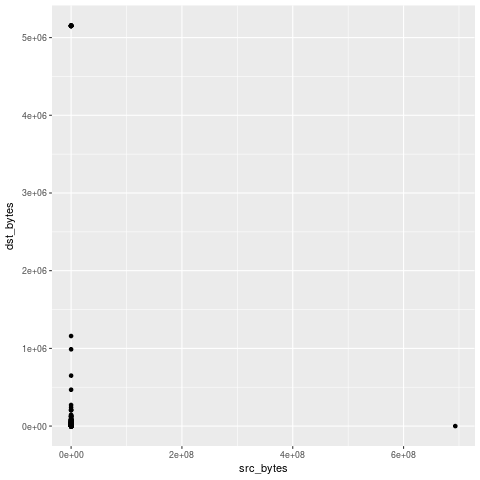

In [27]:
%%R
qplot(x=src_bytes, y=dst_bytes, data=testing_data, geom='point')

In practice, we would want to do the folllowing for each train/test split $i$ :
  1. Train the model based on the $i$-th set of training data and labels.
  2. Apply this trained model on the $i$-th set of testing data.
  3. Save the set of predicted labels.
  
Then return a vector of each of these sets of predicted labels.

For this example, come up with a silly set of predicted labels for each of our 10 training/testing splits. This is the format of predicted labels expected by the performance analsysi in the next section.

In [28]:
%%R
predicted_label_sets <- list(
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[1]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[2]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[3]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[4]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[5]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[6]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[7]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[8]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[9]][[2]]), replace=TRUE, prob=c(0.5, 0.5)),
    sample(c('normal.', 'bad.'), nrow(train_test_splits[[10]][[2]]), replace=TRUE, prob=c(0.5, 0.5))
)

### Logistic Regression
  - Info on Binary Logistic Regression : https://www.statisticssolutions.com/binary-logistic-regression/
  - Logit model in R: https://onlinecourses.science.psu.edu/stat504/node/225/
  - Practical:
    - https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
    - https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html#sphx-glr-auto-examples-linear-model-plot-logistic-l1-l2-sparsity-py
    - https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py
    
This plot might be useful for explanation: https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py
  
 
### Data Preparation
Do I need to prepare the data in any way?
  - **TODO** Transform categorical columns into numeric columns?
  - **TODO** Normalization maybe?
  - **TODO** More?
  

##### Categorical Columns

Choose to do this using one-hot encoding as this avoids assigning implicit meaning or relationships between the categories. For example, if we naively assigned the categories in `protocol_type` the numbers `1,2,3`, we may end up implying to the model that $\text{tcp} \gt \text{icmp}$.

In [29]:
connection_events.select_dtypes(include=[object]).describe()

,protocol_type,service,flag
count,494021,494021,494021
unique,3,66,11
top,icmp,ecr_i,SF
freq,283602,281400,378440


So need to transform the `protocol_type`, `service` and `flag` columns. Consider their values:

In [30]:
set(connection_events.protocol_type), set(connection_events.service), set(connection_events.flag)

({'icmp', 'tcp', 'udp'},
 {'IRC',
  'X11',
  'Z39_50',
  'auth',
  'bgp',
  'courier',
  'csnet_ns',
  'ctf',
  'daytime',
  'discard',
  'domain',
  'domain_u',
  'echo',
  'eco_i',
  'ecr_i',
  'efs',
  'exec',
  'finger',
  'ftp',
  'ftp_data',
  'gopher',
  'hostnames',
  'http',
  'http_443',
  'imap4',
  'iso_tsap',
  'klogin',
  'kshell',
  'ldap',
  'link',
  'login',
  'mtp',
  'name',
  'netbios_dgm',
  'netbios_ns',
  'netbios_ssn',
  'netstat',
  'nnsp',
  'nntp',
  'ntp_u',
  'other',
  'pm_dump',
  'pop_2',
  'pop_3',
  'printer',
  'private',
  'red_i',
  'remote_job',
  'rje',
  'shell',
  'smtp',
  'sql_net',
  'ssh',
  'sunrpc',
  'supdup',
  'systat',
  'telnet',
  'tftp_u',
  'tim_i',
  'time',
  'urh_i',
  'urp_i',
  'uucp',
  'uucp_path',
  'vmnet',
  'whois'},
 {'OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'})

In [31]:
connection_events = pandas.get_dummies(connection_events, columns=["protocol_type", "service", "flag"])

The one-hot-encoding performed by, `pandas.get_dummies`, transforms a single feature that can take $n$ values, into $n$ features that can take $2$ values. This can be seen below:

In [32]:
connection_events.filter(regex='(flag|protocol_type|service).*', axis='columns').head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


The following code runs scikit-learn's [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) [^5] implementation on each of the train/test splits, saving it's predictions for analysis.

In [39]:
model_features = [  # from PCA below
    'count',
    'dst_host_count',
    'dst_host_rerror_rate',
    'dst_host_same_src_port_rate',
    'dst_host_same_srv_rate',
    'dst_host_serror_rate',
    'dst_host_srv_count',
    'dst_host_srv_rerror_rate',
    'dst_host_srv_serror_rate',
    'flag_REJ',
    'flag_S0',
    'flag_SF',
    'logged_in',
    'protocol_type_icmp',
    'protocol_type_tcp',
    'rerror_rate',
    'same_srv_rate',
    'serror_rate',
    'service_ecr_i',
    'service_http',
    'service_private',
    'srv_count',
    'srv_diff_host_rate',
    'srv_rerror_rate',
    'srv_serror_rate',
]

testing_predictions = []

for training_indices, testing_indices in train_test_splits:                                      
    training_data = connection_events.iloc[training_indices]
    training_labels = connection_labels.iloc[training_indices]

    logistic_regression = linear_model.LogisticRegression(
        penalty='l1',
        # The default config applies L2 (Ridge) penalisation. To apply a standard 
        # logistic regression, set C (inverse of regularization strength) to 0 [^10]:
        # C=numpy.inf,
        # solver='lbfgs',
    )
    logistic_regression.fit(training_data, training_labels)
    
    testing_data = connection_events.iloc[testing_indices]
    predicted_labels = logistic_regression.predict(testing_data)
    
    testing_predictions.append(predicted_labels)

**TODO** Describe scikit-learns logisitic regression functions, and how the differ from that which is described in a textbook:
  1. They use L2 (ridge) penalisation by default.
  2. They try to find an optimal probability threshold automatically, how do they do it and why?
    - Plot the probabilities with the computed threshold.
  3. Did they make any other interesting choices?
  

This works far too well by default. Use the `statsmodels` libraries' GLM tools to create a standard logistic regression, then compare.

In [ ]:
standard_scaler = preprocessing.StandardScaler()
normalized_connection_events = pandas.DataFrame(
    standard_scaler.fit_transform(connection_events),
    columns=connection_events.columns,
    index=connection_events.index,
)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(connection_labels)

testing_predictions = []
for training_indices, testing_indices in train_test_splits:
    training_data = normalized_connection_events.iloc[training_indices].filter(model_features, axis='columns')
    training_labels = connection_labels.iloc[training_indices]

    training_labels = label_encoder.transform(training_labels)

    logit = sm.Logit(training_labels, training_data)
    model = logit.fit()

    testing_data = normalized_connection_events.iloc[testing_indices].filter(model_features, axis='columns')
    predictions = model.predict(testing_data)  # seaborn.distplot(predictions)

    threshold = numpy.vectorize(lambda x: 0 if x < 0.5 else 1)
    predictions = threshold(predictions)
    predictions = label_encoder.inverse_transform(predictions)

    testing_predictions.append(predictions)

In [ ]:
testing_predictions[0]

     
     
 ### Feature Selection    
Feature selection:
  - scikit-learn: https://scikit-learn.org/stable/modules/feature_selection.html
  - https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
  - Could do PCA/SVD and look at the first few principle components:
    - their eigenvectors will each weight the original features by important.
    - Using this we could either:
      - do logistical regresion on the principle components,
      - or, identify the most important features from the PCA.
      - talked about here: https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model/34052747
  - "Selecting Features for Intrusion Detection: A Feature Relevance Analysis on KDD 99 Intrusion Detection Datasets"
     -  https://pdfs.semanticscholar.org/1d6e/a73b6e08ed9913d3aad924f7d7ced4477589.pdf
     -  uses *binary discriminant analysis* to pick out features
     
     
#### Why is it interesting?

In real-world scenarios we will often want our classification system to work in real-time, identifying threats as soon as possible after they happen. Reducing the number of features has the potential to speed up the execution time of our classification algorithms, allowing new threats to be found and acted upon promptly. In addition, on large corporate networks with high-traffic loads it may not be feasible to record all 41 of the KDD99 datasets features; reducing the number of features makes recording and storing large colues of traffic possible. 

From "Characterization and classification of malicious Web traffic" [^8]:
>  In addition to learning about characteristics of malicious activities, reducing the number of features by removing the irrelevant and noisy features speeds up the machine learning algorithms and hopefully improves their performance (Liu and Yu, 2005) [^9].

In contrast, if we were to apply PCA to the dataset, then run the model on the transformed data, we would still be required to record, store and process all features in the KDD 99 dataset.

#### Using PCA to select rank feature relevance
  - https://scikit-learn.org/stable/modules/decomposition.html#pca
  - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
pca = decomposition.PCA(
    svd_solver='full',  # force sci-kit learn to compute the exact PCA rather than an estimation
    random_state=random_state,
)

pca.fit(normalized_connection_events)

In [ ]:
pc0 = pca.components_[0]
sorted(zip(connection_events.columns, pc0), key=lambda pair: abs(pair[1]))[-10:]

In [ ]:
pc1 = pca.components_[1]
sorted(zip(connection_events.columns, pc1), key=lambda pair: abs(pair[1]))[-10:]

In [ ]:
pc2 = pca.components_[2]
sorted(zip(connection_events.columns, pc2), key=lambda pair: abs(pair[1]))[-10:]

So the above looks at the three most important principle components, and looks at which of the original features they each value. They are each > 99% comprised of a single feature. In order of importance: src_bytes, dst_bytes, duration.

--> This was wrong, as I hadn't normalized the data before sending it in for PCA. This overly weighted the features with high means. The above code has been fixed to normalise the data beforehand. The above shows a far more equal set of weightings.

We should do a **scree** plot to find out how much each of the PC's contributes, then select the highly weighted features for each of the top-ranked PCs. Then:

  1. Re-run the regression on only those features
  2. Re-run the regression on the first few PC's
  3. Do the reverse and find the least important features, then remove them from the data set and run it again.

In [ ]:
seaborn.scatterplot(data=pca.explained_variance_)

In [ ]:
pca = decomposition.PCA(
    svd_solver='full',  # force sci-kit learn to compute the exact PCA rather than an estimation
    n_components=9,
    random_state=random_state,
)

pca_connection_events = pandas.DataFrame(
    pca.fit_transform(normalized_connection_events),
    columns=["PC0", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"],
    index=connection_events.index,
)

In [ ]:
testing_predictions = []

for training_indices, testing_indices in train_test_splits:                                      
    training_data = normalized_connection_events.iloc[training_indices]
    training_labels = connection_labels.iloc[training_indices]

    logistic_regression = linear_model.LogisticRegression()
    logistic_regression.fit(training_data, training_labels)
    
    testing_data = normalized_connection_events.iloc[testing_indices]
    predicted_labels = logistic_regression.predict(testing_data)
    
    testing_predictions.append(predicted_labels)

### Logistic Regression with Additional Covariates


### Logistic Regression with Penalized Likelihood


### Another approach

## Model Performance and Analysis


Import the predictions from the R session into Python:

In [ ]:
%Rpull predicted_label_sets

In [ ]:
# rpy2 returns an r-type list of character vectors. Convert each set of predictions into a numpy 
# array for processing with numpy/pandas/sklearn etc.
predicted_label_sets = [numpy.array(predicted_labels) for predicted_labels in predicted_label_sets]

In [40]:
## Do the above if we want to evaluate the R model, but we don't, evaluate the predictions from the Python model instead:
predicted_label_sets = testing_predictions

The performance analysis could be done in R or Python. Here is an example in Python [^4]:

In [41]:
true_label_sets = [connection_labels.iloc[testing_indexes] for training_indexes, testing_indexes in train_test_splits]

In [42]:
confusion_matrixes = [
    metrics.confusion_matrix(true_labels, predicted_labels)
    for true_labels, predicted_labels
    in zip(true_label_sets, predicted_label_sets)
]

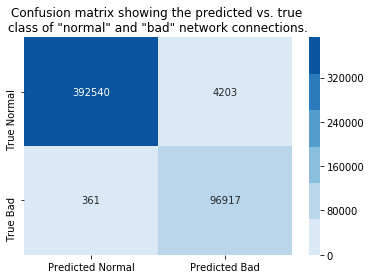

In [43]:
summary_confusion_matrix = sum(confusion_matrixes)
summary_confusion_matrix = pandas.DataFrame(
    data=summary_confusion_matrix, 
    index=['True Bad', 'True Normal'], 
    columns=['Predicted Bad', 'Predicted Normal'],
)

summary_confusion_figure, summary_confusion_axes = matplotlib.pyplot.subplots()
summary_confusion_axes.set_title(
    'Confusion matrix showing the predicted vs. true \n'
    'class of "normal" and "bad" network connections.'
)
seaborn.heatmap(
    summary_confusion_matrix,
    annot=True,
    fmt="d",
    cmap=seaborn.color_palette("Blues"),
    vmin=0,
    ax=summary_confusion_axes,
)

In [ ]:
def sensitivity(confusion_matrix):
    true_positives = confusion_matrix['Predicted Normal']['True Normal']
    false_negatives = confusion_matrix['Predicted Bad']['True Normal']
    return true_positives/(true_positives+false_negatives)

print('Sensitivity: {:.2f}%'.format(
    sensitivity(summary_confusion_matrix)*100
))

In [ ]:
def specificity(confusion_matrix):
    false_positives = confusion_matrix['Predicted Normal']['True Bad']
    true_negatives = confusion_matrix['Predicted Bad']['True Bad']
    return true_negatives/(true_negatives+false_positives)

print('Specificity: {:.2f}%'.format(
    specificity(summary_confusion_matrix)*100
))

Unsuprisingly, modelling the traffic as being uniformly distributed with a 50/50 split did not work particularly well. In fact, it gave sensitivity and specificity measures of approximately $50\%$.

In [ ]:
numpy.mean(connection_events.src_bytes), numpy.mean(normalized_connection_events.src_bytes)

In [ ]:
numpy.mean(connection_events.dst_bytes), numpy.mean(normalized_connection_events.dst_bytes)

Potential Approaches:
  -  Info on PRESS(predicted residual error sum of squares): https://en.wikipedia.org/wiki/PRESS_statistic
  - ROC Curve 
    - <https://en.wikipedia.org/wiki/Receiver_operating_characteristic>
    - Practical Statistics for Data Science, 1st ed., by Peter Bruce and Andrew Bruce (O’Reilly Media, 2017).


### Notes on real-world context

The dataset contains $20\%$ normal traffic and $80\%$ malicious. This is consistent with recent real-world analysis on public-facing web services performed by Incapsula [^6]. Our use case, however, is intrusion detection within internal networks [^2], where malicious traffic should be a rarity.

This means that  performance metric focused on the KDD Cup 99 data set may not be applicable to models used for real-world scenarios. In particular, an overly sensitive model would be favoured in the KDD Cup 99 data set, since its error would be smaller in ratio compared to a real world data set, which may have less than $5\%$  malicious traffic internally.

## Introduction

The KDD Cup 99 data set [^3], being one of the few publically available data sets of this size and nature, has receieved a large amount of study and analysis within academic community. This has provided a pool of prior work to learn from. 

In particular, Katos 2007 [^7] evaluated three key approaches to detecting normal and malicious connections within the KDD 99 data set  - cluster, discriminant and logit analysis.

This summary of the data from [] is quite nice:

> The KDD 99 intrusion detection datasets are based on the 1998 DARPA initiative to provide designers of intrusion detection systems (IDS) with a benchmark on which to evaluate different methodologies [1]. To do so, a simulation is made of a factitious military network consisting of three ‘target’ machines running various operating systems and services. Additional three machines are then used to spoof different IP addresses, thus generating traffic between different IP addresses. Finally, there is a sniffer that records all network traffic using the TCP dump format. The total simulated period is seven weeks. Normal connections are created to profile that expected in a military network and attacks fall into one of four categories: User to Root; Remote to Local; Denial of Service; and Probe.
  > - Denial of Service (dos): Attacker tries to prevent legitimate users from using a service. 
  > - Remote to Local (r2l): Attacker does not have an account on the victim machine, hence tries to gain access. 
  > - User to Root (u2r): Attacker has local access to the victim machine and tries to gain super user privileges. 
  > - Probe: Attacker tries to gain information about the target host. 
  >
  > In 1999, the original TCP dump files were preprocessed for utilization in the Intrusion Detection System benchmark of the International Knowledge Discovery and Data Mining Tools Competition. To do so, packet information in the TCP dump file is summarized into connections. Specifically, “a connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows from a source IP address to a target IP address under some well defined protocol”.

In [ ]:
set(connection_events['is_host_login']), set(connection_events['num_outbound_cmds']), set(connection_events['is_host_login'])

In [12]:
connection_events.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

# Reflection

We could have considered a network-based approach in a compettion setting and looked if that has bettter performance.

## References

[^1]: rpy2, https://rpy2.bitbucket.io/.

[^2]: KDD-CUP-99 Task Description, http://kdd.ics.uci.edu/databases/kddcup99/task.html.

[^3]: Hettich, S. and Bay, S. D. (1999). The UCI KDD Archive [http://kdd.ics.uci.edu]. Irvine, CA: University of California, Department of Information and Computer Science.

[^4]: Data Science Toolbox: Assignment 1, https://github.com/dj311/data-science-toolbox-1.

[^5]: Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

[^6]: Incapsula: Annual Bot Traffic Report, https://www.incapsula.com/about/press-releases/incapsula-finds-malicious-bots-account-for-approximately-30-percent-of-internet-traffic/

[^7]: Katos, V., 2007. Network intrusion detection: Evaluating cluster, discriminant, and logit analysis. Information Sciences, 177(15), pp.3060-3073. https://doi.org/10.1016/j.ins.2007.02.034

[^8]: Goseva-Popstojanova, Katerina, et al. "Characterization and classification of malicious Web traffic." computers & security 42 (2014): 92-115. https://doi.org/10.1016/j.cose.2014.01.006

[^9]: Liu, Huan, and Lei Yu. "Toward integrating feature selection algorithms for classification and clustering." IEEE Transactions on knowledge and data engineering 17.4 (2005): 491-502. https://doi.org/10.1109/TKDE.2005.66